In [2]:
import math, os, random, time
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, utils as vutils
import matplotlib.pyplot as plt

def set_seed(s=42):
    random.seed(s); torch.manual_seed(s); torch.cuda.manual_seed_all(s)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
set_seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#  Data
transform = transforms.Compose([
    transforms.ToTensor(),                    # [0,1]
    # FashionMNIST is grayscale 28x28 already
])

train_set = datasets.FashionMNIST(root="./data", train=True, download=True, transform=transform)
val_set   = datasets.FashionMNIST(root="./data", train=False, download=True, transform=transform)

BATCH_SIZE = 128
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_set,   batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

#  Model

from architecture import VAE
model = VAE().to(device)

#  Loss: MSE recon + KL
mse = nn.MSELoss(reduction="sum")   # sum over pixels will be divided by batch later

def kl_normal_standard(mu, logvar):
    # KL( N(mu, diag(sigma^2)) || N(0, I) ) = -1/2 * sum(1 + logvar - mu^2 - exp(logvar))
    return -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

def elbo_components(x, recon, mu, logvar):
    recon_loss = mse(recon, x)  # sum over all pixels and batch
    kl = kl_normal_standard(mu, logvar)
    return recon_loss, kl

#  Optimizer
opt = optim.Adam(model.parameters(), lr=2e-3)

#  Grad clip to stabilize training
GRAD_CLIP = 5.0

#  Train/Val loops
def run_epoch(loader, train=True, beta=1.0):
    model.train(train)
    total_rec, total_kl, total = 0.0, 0.0, 0
    for x, _ in loader:
        x = x.to(device)
        recon, mu, logvar = model(x)
        rec, kl = elbo_components(x, recon, mu, logvar)
        # Average per-sample so logs are comparable across batch sizes
        loss = (rec + beta * kl) / x.size(0)

        if train:
            opt.zero_grad(set_to_none=True)
            loss.backward()
            if GRAD_CLIP: nn.utils.clip_grad_norm_(model.parameters(), GRAD_CLIP)
            opt.step()

        total_rec += rec.item()
        total_kl  += kl.item()
        total     += x.size(0)

    # report per-sample averages
    return (total_rec/total, total_kl/total, (total_rec + beta*total_kl)/total)

EPOCHS = 30
history = {"train_rec":[], "train_kl":[], "train_total":[],
           "val_rec":[], "val_kl":[], "val_total":[], "beta":[]}

# simple constant beta=1 training for Task 1
for epoch in range(1, EPOCHS+1):
    beta = 1.0
    tr_rec, tr_kl, tr_tot = run_epoch(train_loader, train=True,  beta=beta)
    va_rec, va_kl, va_tot = run_epoch(val_loader,   train=False, beta=beta)

    history["beta"].append(beta)
    history["train_rec"].append(tr_rec)
    history["train_kl"].append(tr_kl)
    history["train_total"].append(tr_tot)
    history["val_rec"].append(va_rec)
    history["val_kl"].append(va_kl)
    history["val_total"].append(va_tot)

    print(f"[{epoch:02d}/{EPOCHS}] "
          f"beta={beta:.3f} | "
          f"Train: rec {tr_rec:.2f} kl {tr_kl:.2f} tot {tr_tot:.2f} || "
          f"Val:   rec {va_rec:.2f} kl {va_kl:.2f} tot {va_tot:.2f}")

# Save logs and model
os.makedirs("artifacts", exist_ok=True)
torch.save({"model": model.state_dict(), "history": history}, "artifacts/vae_fmnist.pt")


[01/30] beta=1.000 | Train: rec 28.63 kl 6.13 tot 34.76 || Val:   rec 20.83 kl 6.97 tot 27.80
[02/30] beta=1.000 | Train: rec 19.45 kl 6.95 tot 26.39 || Val:   rec 18.84 kl 6.95 tot 25.79
[03/30] beta=1.000 | Train: rec 18.05 kl 7.22 tot 25.27 || Val:   rec 18.38 kl 6.69 tot 25.06
[04/30] beta=1.000 | Train: rec 17.37 kl 7.33 tot 24.70 || Val:   rec 17.73 kl 7.08 tot 24.81
[05/30] beta=1.000 | Train: rec 16.99 kl 7.42 tot 24.40 || Val:   rec 16.76 kl 7.59 tot 24.35
[06/30] beta=1.000 | Train: rec 16.66 kl 7.51 tot 24.17 || Val:   rec 16.51 kl 7.66 tot 24.17
[07/30] beta=1.000 | Train: rec 16.43 kl 7.56 tot 23.98 || Val:   rec 16.57 kl 7.37 tot 23.93
[08/30] beta=1.000 | Train: rec 16.26 kl 7.60 tot 23.86 || Val:   rec 16.02 kl 7.78 tot 23.80
[09/30] beta=1.000 | Train: rec 16.10 kl 7.65 tot 23.75 || Val:   rec 16.45 kl 7.31 tot 23.75
[10/30] beta=1.000 | Train: rec 15.91 kl 7.68 tot 23.60 || Val:   rec 16.07 kl 7.62 tot 23.69
[11/30] beta=1.000 | Train: rec 15.75 kl 7.77 tot 23.52 || V

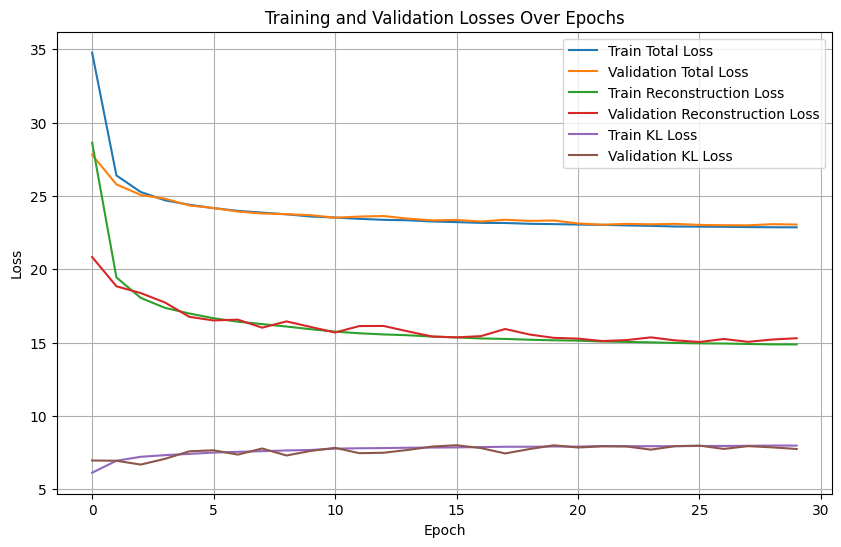

In [3]:
# Plot history
plt.figure(figsize=(10, 6))
plt.plot(history['train_total'], label='Train Total Loss')
plt.plot(history['val_total'], label='Validation Total Loss')
plt.plot(history['train_rec'], label='Train Reconstruction Loss')
plt.plot(history['val_rec'], label='Validation Reconstruction Loss')
plt.plot(history['train_kl'], label='Train KL Loss')
plt.plot(history['val_kl'], label='Validation KL Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

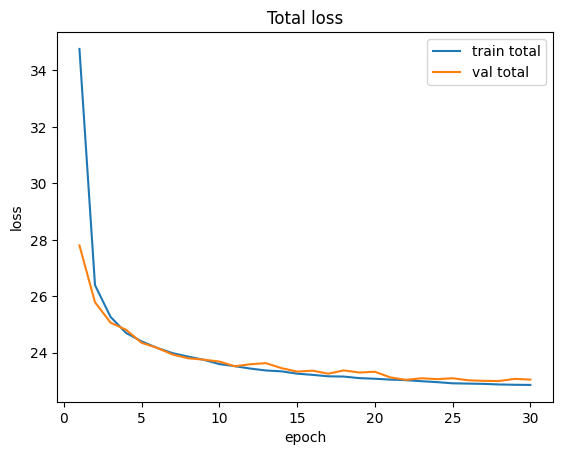

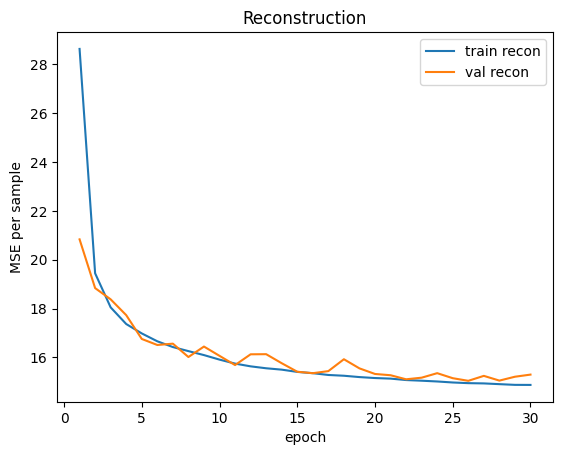

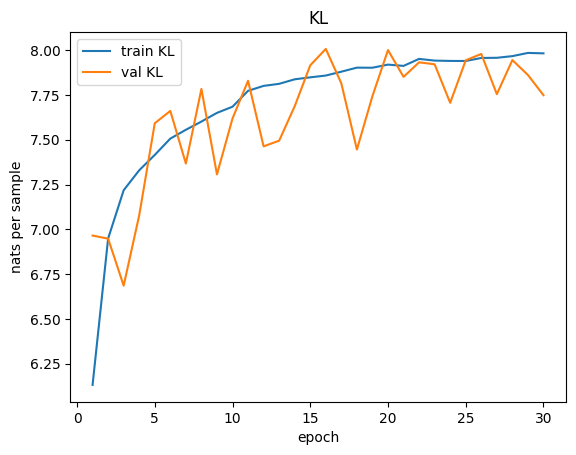

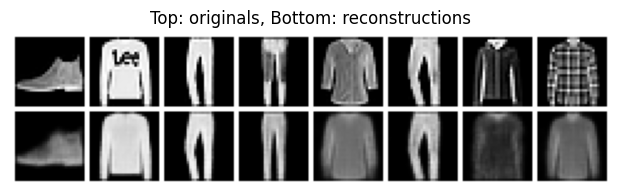

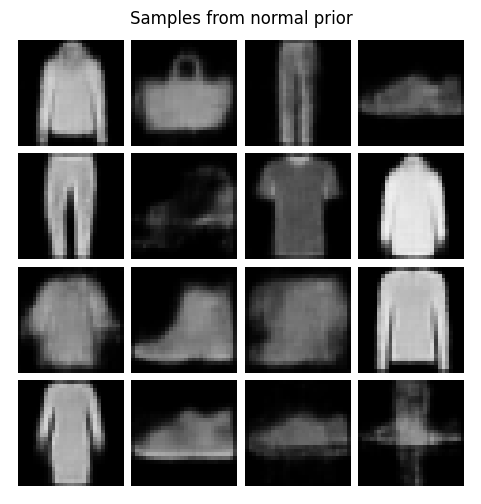

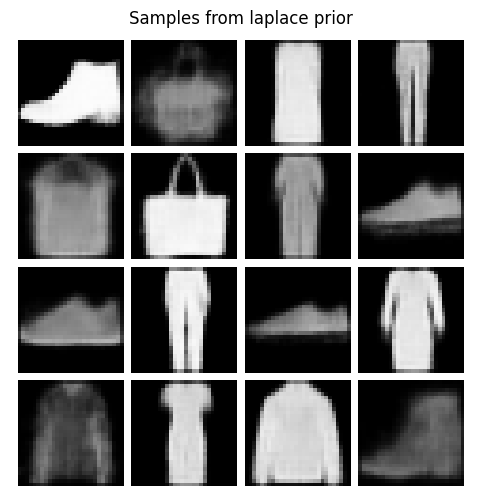

In [4]:
@torch.no_grad()
def show_reconstructions(n=8):
    model.eval()
    x, _ = next(iter(val_loader))
    x = x[:n].to(device)
    recon, _, _ = model(x)
    grid = vutils.make_grid(torch.cat([x, recon], dim=0), nrow=n, pad_value=1.0)
    plt.figure(figsize=(n, 2))
    plt.axis("off"); plt.title("Top: originals, Bottom: reconstructions")
    plt.imshow(grid.cpu().permute(1,2,0).squeeze(), cmap="gray")
    plt.show()

@torch.no_grad()
def sample_from_prior(n=16, prior="normal"):
    model.eval()
    # infer latent dim from mu during a forward pass on a tiny batch
    x, _ = next(iter(val_loader))
    x = x[:1].to(device)
    _, mu, _ = model(x)
    zdim = mu.shape[1]

    if prior == "normal":
        z = torch.randn(n, zdim, device=device)
    elif prior == "laplace":
        # Laplace(0,1).sample()
        lap = torch.distributions.Laplace(loc=torch.zeros(zdim, device=device), scale=torch.ones(zdim, device=device))
        z = lap.sample((n,))
    else:
        raise ValueError("prior must be 'normal' or 'laplace'")

    # decode-only path: assuming VAE has a decode(z) or decoder(z)
    if hasattr(model, "decode"):
        imgs = model.decode(z)
    else:
        # If architecture exposes a 'decoder' module
        imgs = model.decoder(z)

    grid = vutils.make_grid(imgs, nrow=int(math.sqrt(n)), pad_value=1.0)
    plt.figure(figsize=(6,6))
    plt.axis("off"); plt.title(f"Samples from {prior} prior")
    plt.imshow(grid.cpu().permute(1,2,0).squeeze(), cmap="gray")
    plt.show()

def plot_losses(history):
    xs = range(1, len(history["train_total"])+1)
    plt.figure(); plt.plot(xs, history["train_total"], label="train total")
    plt.plot(xs, history["val_total"],   label="val total"); plt.xlabel("epoch"); plt.ylabel("loss"); plt.legend(); plt.title("Total loss")
    plt.figure(); plt.plot(xs, history["train_rec"], label="train recon")
    plt.plot(xs, history["val_rec"],   label="val recon"); plt.xlabel("epoch"); plt.ylabel("MSE per sample"); plt.legend(); plt.title("Reconstruction")
    plt.figure(); plt.plot(xs, history["train_kl"], label="train KL")
    plt.plot(xs, history["val_kl"],   label="val KL"); plt.xlabel("epoch"); plt.ylabel("nats per sample"); plt.legend(); plt.title("KL")
    plt.show()

# call after training:
plot_losses(history)
show_reconstructions(n=8)
sample_from_prior(n=16, prior="normal")
sample_from_prior(n=16, prior="laplace")


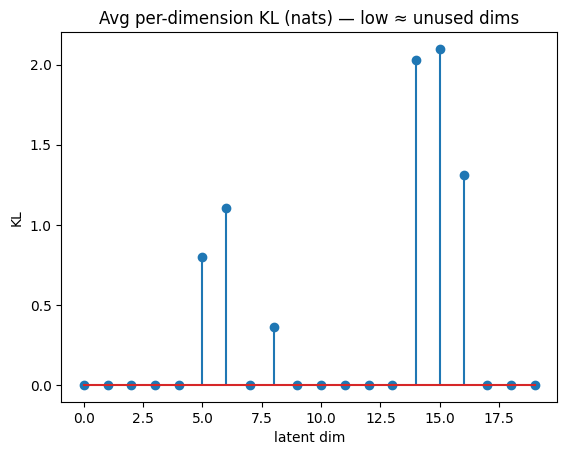

Mean |mu| across dims (lower ≈ closer to prior mean):
[0.01753526 0.04362604 0.0040834  0.0031585  0.02009211 0.07844752
 0.03521003 0.02037184 0.06009704 0.02184301 0.00939641 0.02512023
 0.01715139 0.03444309 0.07379159 0.04893012 0.0531049  0.01131726
 0.00419823 0.02459726]
Mean logvar across dims (≈0 means var ~ 1):
[-2.0975057e-02 -1.3847530e-02 -5.6832889e-03 -7.7015832e-03
 -2.6408961e-02 -1.6777885e+00 -2.2694016e+00 -2.0041941e-03
 -7.3168087e-01  2.5753400e-03 -2.2047838e-02 -2.9426817e-02
 -8.5356021e-03 -2.3386558e-03 -4.1056337e+00 -4.1835051e+00
 -2.6950746e+00 -7.3109358e-04 -4.6359818e-02 -6.1994134e-03]
Total KL per sample (approx): 7.724 nats


In [6]:
@torch.no_grad()
def latent_diagnostics(loader, max_batches=10):
    model.eval()
    kls, mus, logvars = [], [], []
    batches = 0
    for x, _ in loader:
        x = x.to(device)
        _, mu, logvar = model(x)
        # per-dimension KL for diagnostics: 0.5*(mu^2 + exp(logvar) - 1 - logvar)
        per_dim_kl = 0.5*(mu.pow(2) + logvar.exp() - 1.0 - logvar)
        kls.append(per_dim_kl.mean(dim=0).cpu())  # average over batch
        mus.append(mu.mean(dim=0).abs().cpu())
        logvars.append(logvar.mean(dim=0).cpu())
        batches += 1
        if batches >= max_batches: break
    kls = torch.stack(kls).mean(0)
    mus = torch.stack(mus).mean(0)
    logvars = torch.stack(logvars).mean(0)

    plt.figure(); plt.stem(kls.numpy())
    plt.title("Avg per-dimension KL (nats) — low ≈ unused dims"); plt.xlabel("latent dim"); plt.ylabel("KL")
    plt.show()

    print("Mean |mu| across dims (lower ≈ closer to prior mean):")
    print(mus.numpy())
    print("Mean logvar across dims (≈0 means var ~ 1):")
    print(logvars.numpy())
    print(f"Total KL per sample (approx): {kls.sum().item():.3f} nats")

# usage
latent_diagnostics(val_loader)

In [7]:
def sigmoid_anneal(t, t0=5, k=0.5):
    # smooth increase from ~0 to ~1 over epochs; tune t0 (midpoint) and k (slope)
    return float(1 / (1 + math.exp(-k*(t - t0))))

def linear_anneal(epoch, start=0, end=1, warmup_epochs=10):
    if epoch <= warmup_epochs:
        return start + (end-start) * (epoch / warmup_epochs)
    return end

# Re-run training with annealed beta
model = VAE().to(device)
opt = optim.Adam(model.parameters(), lr=2e-3)
history2 = {k:[] for k in history.keys()}

EPOCHS = 40
WARMUP = 15  # try 10–30
for epoch in range(1, EPOCHS+1):
    beta = linear_anneal(epoch, start=0.0, end=1.0, warmup_epochs=WARMUP)
    tr_rec, tr_kl, tr_tot = run_epoch(train_loader, train=True,  beta=beta)
    va_rec, va_kl, va_tot = run_epoch(val_loader,   train=False, beta=beta)

    history2["beta"].append(beta)
    history2["train_rec"].append(tr_rec); history2["train_kl"].append(tr_kl); history2["train_total"].append(tr_tot)
    history2["val_rec"].append(va_rec);   history2["val_kl"].append(va_kl);   history2["val_total"].append(va_tot)

    print(f"[{epoch:02d}/{EPOCHS}] beta={beta:.3f} | "
          f"Train rec {tr_rec:.2f} kl {tr_kl:.2f} tot {tr_tot:.2f} || "
          f"Val rec {va_rec:.2f} kl {va_kl:.2f} tot {va_tot:.2f}")

torch.save({"model": model.state_dict(), "history": history2}, "artifacts/vae_fmnist_warmup.pt")


[01/40] beta=0.067 | Train rec 25.26 kl 26.36 tot 27.01 || Val rec 15.79 kl 28.61 tot 17.69
[02/40] beta=0.133 | Train rec 14.51 kl 22.89 tot 17.56 || Val rec 13.36 kl 20.91 tot 16.15
[03/40] beta=0.200 | Train rec 13.05 kl 18.55 tot 16.76 || Val rec 12.53 kl 18.79 tot 16.28
[04/40] beta=0.267 | Train rec 12.68 kl 16.46 tot 17.07 || Val rec 12.43 kl 15.88 tot 16.67
[05/40] beta=0.333 | Train rec 12.66 kl 15.10 tot 17.69 || Val rec 12.47 kl 15.47 tot 17.62
[06/40] beta=0.400 | Train rec 12.77 kl 13.94 tot 18.34 || Val rec 12.90 kl 13.77 tot 18.41
[07/40] beta=0.467 | Train rec 12.97 kl 13.03 tot 19.05 || Val rec 13.12 kl 12.63 tot 19.02
[08/40] beta=0.533 | Train rec 13.18 kl 12.27 tot 19.73 || Val rec 12.80 kl 13.26 tot 19.87
[09/40] beta=0.600 | Train rec 13.43 kl 11.59 tot 20.38 || Val rec 13.41 kl 11.63 tot 20.39
[10/40] beta=0.667 | Train rec 13.73 kl 10.95 tot 21.04 || Val rec 13.69 kl 10.90 tot 20.96
[11/40] beta=0.733 | Train rec 13.96 kl 10.44 tot 21.62 || Val rec 14.08 kl 10.4

In [8]:
def kl_free_bits(mu, logvar, lam=0.8):
    # per-dim KL
    per_dim = 0.5*(mu.pow(2) + logvar.exp() - 1.0 - logvar)
    # apply floor then sum
    return torch.sum(torch.clamp(per_dim.mean(dim=0), min=lam))

# swap in the training step:
def elbo_components_freebits(x, recon, mu, logvar, lam=0.8):
    rec = mse(recon, x)
    kl  = kl_free_bits(mu, logvar, lam=lam)
    return rec, kl


In [10]:
enc_params = list(model.encoder.parameters()) if hasattr(model, "encoder") else []
dec_params = list(model.decoder.parameters()) if hasattr(model, "decoder") else []
opt = optim.Adam([
    {"params": enc_params, "lr": 3e-3},
    {"params": dec_params, "lr": 1.5e-3},
    # add any other params (e.g., final heads) accordingly
])
